In [71]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import json
import re
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
from scipy.stats import sem, mannwhitneyu
import sys
sys.path.insert(0, 'src')
# from misc_scripts import scripts
from utils import utils


## Loading dataset with cleaned summaries

In [72]:
# Define the path to the preprocessed data
preprocessed_file_path = 'data/preprocessed_movies.parquet'  # Ensure this path matches where you saved the file

df_movies = pd.read_parquet(preprocessed_file_path)

## Perform some cleaning


In [73]:

# Convert release date to a datetime if not already
df_movies['Movie_release_date'] = pd.to_datetime(df_movies['Movie_release_date'], errors='coerce')

df_movies.rename(columns={'Movie_countxries': 'Movie_countries'}, inplace=True)

mapping = {
    'Hong Kong': 'China',
    'West Germany': 'Germany',
    'Soviet Union': 'Russia',
    'Czechoslovakia': 'Czechia',
    'German Democratic Republic': 'Germany',
    'Yugoslavia': 'Serbia',
    'England': 'United Kingdom',
    'Weimar Republic': 'Germany',
    'Scotland': 'United Kingdom',
    'Korea': 'South Korea',
    'Burma': 'Myanmar',
    'Nazi Germany': 'Germany',
    'Republic of Macedonia': 'North Macedonia',
    'Socialist Federal Republic of Yugoslavia': 'Serbia',
    'Serbia and Montenegro': 'Serbia',
    'Kingdom of Great Britain': 'United Kingdom',
    'Federal Republic of Yugoslavia': 'Serbia',
    'Georgian SSR': 'Georgia',
    'Palestinian territories': 'Palestine',
    'Slovak Republic': 'Slovakia',
    'Mandatory Palestine': 'Palestine',
    'Uzbek SSR': 'Uzbekistan',
    'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'Ukranian SSR': 'Ukraine',
    'Isle of Man': 'United Kingdom',
    'Soviet occupation zone': 'Germany',
    'Malayalam Language': 'India',  # Language, assuming tied to India
    'Crime': 'Ukraine',  # Not clear, omitted
    'Iraqi Kurdistan': 'Iraq',
    'German Language': 'Germany',  # Language, assuming tied to Germany
    'Palestinian Territories': 'Palestine',
    'Kingdom of Italy': 'Italy',
    'Ukrainian SSR' : 'Ukraine',
    'Republic of China' : 'China',
    'Makau' : 'China',
    'Aruba' : 'Netherlands'
}

df_movies["Movie_countries"] = df_movies["Movie_countries"].apply(lambda x: list(json.loads(x).values()))
df_movies["Movie_countries"] = df_movies["Movie_countries"].apply(
    lambda countries: [mapping.get(country, country) for country in countries]
)


## Cleaning summaries


This code cleans and filters movie summaries. It removes rows with invalid summaries, tokenizes the text, and identifies words that are too common or too rare. It then filters out these words, leaving only the useful tokens and key fields in the dataset.

In [74]:
# Drop rows without Clean_Summary or where Clean_Summary is too short
df_movies = df_movies.dropna(subset=['Clean_Summary'])
df_movies = df_movies[df_movies['Clean_Summary'].str.strip() != ""]


# tokenize each summary into a list of words
df_movies["tokens"] = df_movies["Clean_Summary"].apply(lambda x: x.split())

# Count how often each word appears across all documents
word_counts = Counter(word for tokens in df_movies["tokens"] for word in tokens)

# Compute how many documents each word appears in:
word_in_docs = {}
for tokens in df_movies["tokens"]:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_in_docs[token] = word_in_docs.get(token, 0) + 1

# set thresholds
too_common_threshold = 0.5 * len(df_movies)     #word appears in more than 50% of movies

too_rare_threshold = 5                          #word appear in less than 5 documents

too_common_words = {w for w, count in word_in_docs.items() if count > too_common_threshold}
too_rare_words = {w for w, count in word_in_docs.items() if count < too_rare_threshold}

#fitler too common or too rare words
df_movies["tokens_filtered"] = df_movies["tokens"].apply(
    lambda tokens: [w for w in tokens if 
                     w not in too_rare_words]
)

df_movies=df_movies[['Wikipedia_movie_ID',	'Movie_name',	'Movie_countries',	'Movie_release_date',	'Female Percentage',	'tokens_filtered']]

In [75]:
df=df_movies
df.head()

,Wikipedia_movie_ID,Movie_name,Movie_countries,Movie_release_date,Female Percentage,tokens_filtered
0,975900,Ghosts of Mars,[United States of America],2001-08-24,35.294118,"[set, second, half, nd, century, depict, mar, ..."
1,9363483,White Of The Eye,[United Kingdom],NaT,50.000000,"[series, murder, rich, young, woman, arizona, ..."
2,261236,A Woman in Flames,[Germany],NaT,33.333333,"[eva, upper, class, housewife, frustrated, lea..."
3,18998739,The Sorcerer's Apprentice,[South Africa],NaT,20.000000,"[year, evil, morgana, return, claim, talisman,..."
4,6631279,Little city,[United States of America],1997-04-04,66.666667,"[adam, san, artist, work, cab, driver, hard, t..."


## Semantic analysis

This code establishes various thematic or emotional categories, associates them with specific seed words, and uses a pre-trained language model to generate related word embeddings. By identifying which tokens in a dataset are semantically closest to each category, it creates comprehensive sentiment lexicons. These lexicons are then used to compute sentiment-like scores for each document.

**Step-by-Step Explanation**:  
1. **Define Categories and Seed Words**:  
   Sets of seed words are assigned to categories (e.g., love, aggression, violence) to represent thematic or emotional dimensions.

2. **Load Embedding Model**:  
   A sentence transformer model is loaded to embed words into a numerical vector space.

3. **Compute Category Centroids**:  
   For each category, embeddings of the seed words are averaged to form a centroid vector, representing the category’s semantic center.

4. **Find Top Similar Words**:  
   By comparing each category’s centroid to all token embeddings in the movie dataset, the code finds the most semantically similar words and uses them to expand each category’s lexicon.

5. **Generate Sentiment Lexicons**:  
   These expanded sets of words form detailed lexicons that represent each category’s semantic field.

6. **Compute Sentiment Scores**:  
   Each document’s tokens are matched against these lexicons, and the frequency of matching words is used to compute category-specific sentiment-like scores.


In [76]:
# Define Categories and Seed Words 

love_words = {
    "love", "romance", "affection", "adore", "loving", "cherish", "passion",
    "attraction", "intimacy", "devotion"
}

aggression_words = {
    "aggression", "anger", "hostile", "rage", "fury", "wrath", "irritation", 
    "belligerence", "antagonism", "resentment"
}

violence_words = {
    "murder", "kill", "violence", "attack", "weapon", "war", "brutal", "bloodshed", 
    "assault", "slaughter"
}

family_words = {
    "family", "mother", "father", "brother", "sister", "child", "children", 
    "daughter", "son", "parent"
}

happiness_words = {
    "happy", "joy", "pleasure", "delight", "glad", "cheerful", "elated", 
    "content", "bright", "optimistic"
}

sadness_words = {
    "sad", "sorrow", "grief", "melancholy", "depressed", "downcast", "tearful", 
    "unhappy", "miserable", "lament"
}

fear_words = {
    "fear", "scared", "frightened", "afraid", "terrified", "anxious", "uneasy", 
    "wary", "alarmed", "panic"
}

empowerment_words = {
    "empower", "empowered", "empowering", "independent", "strong", "leadership",
    "authority", "self-reliant", "resilient", "determined"
}

relationships_words = {
    "friendship", "friend", "friends", "romance", "romantic", "relationship",
    "partner", "partners", "mentorship", "mentor"
}

career_words = {
    "career", "profession", "job", "work", "office", "business", "entrepreneur",
    "startup", "manager", "lead"
}

social_issues_words = {
    "feminism", "equality", "diversity", "activism", "social justice",
    "discrimination", "inclusion", "rights", "empowerment", "advocacy"
}

emotional_complexity_words = {
    "anxiety", "hope", "despair", "joy", "grief", "anticipation", "surprise",
    "trust", "disgust", "anticipate"
}

heroism_words = {
    "hero", "heroic", "sacrifice", "courage", "bravery", "valor", "chivalry",
    "noble", "selfless", "altruism"
}

conflict_resolution_words = {
    "conflict", "resolve", "resolution", "battle", "fight", "struggle",
    "tension", "dispute", "argument", "clash"
}

adventure_words = {
    "adventure", "exploration", "journey", "quest", "voyage", "expedition",
    "trek", "odyssey", "discover", "explore"
}

mystery_words = {
    "mystery", "suspense", "intrigue", "secret", "unknown", "puzzle",
    "enigma", "clue", "detective", "investigation"
}

technology_words = {
    "technology", "innovate", "innovation", "science", "future", "robot",
    "AI", "artificial intelligence", "cyber", "digital"
}

# Combine all sentiment categories into a dictionary
categories = {
    "love_score": love_words,
    "aggression_score": aggression_words,
    "violence_score": violence_words,
    "family_score": family_words,
    "happiness_score": happiness_words,
    "sadness_score": sadness_words,
    "fear_score": fear_words,
    "empowerment_score": empowerment_words,
    "relationships_score": relationships_words,
    "career_score": career_words,
    "social_issues_score": social_issues_words,
    "emotional_complexity_score": emotional_complexity_words,
    "heroism_score": heroism_words,
    "conflict_resolution_score": conflict_resolution_words,
    "adventure_score": adventure_words,
    "mystery_score": mystery_words,
    "technology_score": technology_words
}


After the categories have been defined all tokens need to be emebedded to be able to calculate cosine similarity. So a simple emebedding model is loaded.

In [77]:
# Load the Embedding Model
model = SentenceTransformer("all-MiniLM-L6-v2")


For every category the centroid is calculated by calculating the mean of the set of embedded seed words for each category. Defining seed words allow us to have an idea of the semantic center of each category.

In [78]:
# Compute centroid embeddings for each category

category_centroids = {}
for cat, seed_words in categories.items():
    seed_embeddings = model.encode(list(seed_words), batch_size=32) #calculate embeddings of seed words
    centroid = np.mean(seed_embeddings, axis=0)                     #calculate centroid of emebeddings of see words
    category_centroids[cat] = centroid                              #append to list


This code extracts unique tokens from the movie dataset, encodes them into vector embeddings using the model, and stores these embeddings in a dictionary for later use.


In [79]:
# Flatten all tokens and get unique tokens
print("Collecting unique tokens...")
all_tokens = set(token for tokens in df['tokens_filtered'] for token in tokens)
all_tokens = list(all_tokens)
print(f"Total unique tokens: {len(all_tokens)}")

# Encode all unique tokens in batches and create a token-to-embedding map
batch_size = 1024
token_embeddings = {}

for i in range(0, len(all_tokens), batch_size):
    batch_tokens = all_tokens[i:i+batch_size]
    embeddings = model.encode(batch_tokens, batch_size=256)
    for token, embedding in zip(batch_tokens, embeddings):
        token_embeddings[token] = embedding



Total unique tokens: 30362


In [80]:
# Generate Sentiment Lexicons
sentiment_lexicons = {}
top_k = 100  # Number of top similar words to consider for each category

#For every category we get the top n similar words by calculating the cosine similarities bewtween the centroids and the set of unique tokens in the movie dataset
for cat, centroid in category_centroids.items():
    top_words = utils.get_top_n_similar_words(centroid, token_embeddings, top_n=top_k)
    sentiment_lexicons[cat] = set([word for word, score in top_words])

#Display top 10 words for each category
for cat, words in sentiment_lexicons.items():
    print(f"\nCategory: {cat.replace('_score', '').capitalize()}")
    print("-" * (10 + len(cat)))
    print(", ".join(list(words)[:10]) + ", ...")  # Display first 10 words for brevity



Category: Love
--------------------
desire, unloving, devotion, romanticism, fantasise, feeling, funloving, enamoured, heart, intimacy, ...

Category: Aggression
--------------------------
conflict, bullying, hatred, angrily, harassment, upsetting, threatening, war, antagonistic, irritated, ...

Category: Violence
------------------------
conflict, tortured, gunfight, gunfire, crisis, threatening, brutally, war, punishment, genocide, ...

Category: Family
----------------------
incest, son, child, grandpa, brothers, teen, maternal, soni, junior, fatherinlaw, ...

Category: Happiness
-------------------------
gleefully, joyfully, feeling, thriving, blissfully, joyously, satisfied, unhappy, delightfully, pleasurable, ...

Category: Sadness
-----------------------
distress, feeling, upset, disdainfully, unhappiness, whimpering, depression, depressing, upsetting, remorselessly, ...

Category: Fear
--------------------
feeling, crisis, threatening, danger, claustrophobic, exposed, frighten

To more easily visualise the category centroids and the top 100 words for each category, we also plot the emebedded vectors in a 3d space, after performing dimensionality reduciton

In [81]:
# Collect centroids and their top-N similar words
data = []

for category, centroid in category_centroids.items():
    top_words = sentiment_lexicons[category]  # Set of top-N words
    for word in top_words:
        embedding = token_embeddings.get(word)
        if embedding is not None:
            data.append({
                'category': category,
                'word': word,
                'embedding': embedding,
                'is_centroid': False
            })
    # Also add the centroid itself
    data.append({
        'category': category,
        'word': 'Centroid',
        'embedding': centroid,
        'is_centroid': True
    })

df_embeddings = pd.DataFrame(data)


In [82]:
import umap
from sklearn.decomposition import PCA

# Extract embeddings
embeddings = np.stack(df_embeddings['embedding'].values)



In [83]:
df_embeddings.head()

,category,word,embedding,is_centroid
0,love_score,desire,"[-0.023013774, 0.049660675, 0.0053385994, 0.08...",False
1,love_score,unloving,"[-0.058127984, 0.017276311, 0.04386229, 0.1042...",False
2,love_score,devotion,"[0.009249302, 0.07900597, 0.03560082, 0.020437...",False
3,love_score,romanticism,"[-0.008984301, 0.04947597, 0.09295951, 0.08251...",False
4,love_score,fantasise,"[0.058427017, -0.017351551, 0.054922763, 0.024...",False


In [84]:
import pandas as pd
import numpy as np
import umap
import plotly.graph_objects as go
import plotly.express as px
import warnings

# Suppress the specific UMAP warning
warnings.filterwarnings(
    "ignore",
    message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism."
)

# --- Dimensionality Reduction with UMAP ---
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(embeddings)

# --- Assign 'x', 'y', 'z' Columns to df_embeddings ---
df_embeddings[['x', 'y', 'z']] = embedding_3d

# --- Create Copies of Sliced DataFrames ---
df_centroids = df_embeddings[df_embeddings['is_centroid']].copy()
df_words = df_embeddings[~df_embeddings['is_centroid']].copy()

# --- Create 'display_category' ---
df_words['display_category'] = df_words['category'].str.replace('_score', '', regex=False)
df_centroids['display_category'] = df_centroids['category'].str.replace('_score', '', regex=False)

# --- Define Categories and Color Mapping ---
categories = pd.concat([
    df_words['display_category'],
    df_centroids['display_category']
]).unique()

color_palette = px.colors.qualitative.Plotly
color_discrete_map = {cat: color_palette[i % len(color_palette)] for i, cat in enumerate(categories)}

# --- Clip Extreme Outliers to Improve Visibility ---
x_min, x_max = np.percentile(df_words['x'], [1, 99])
y_min, y_max = np.percentile(df_words['y'], [1, 99])
z_min, z_max = np.percentile(df_words['z'], [1, 99])

# --- Create 3D Plot ---
fig_3d = go.Figure()

# Add word traces per category
for cat in categories:
    cat_df = df_words[df_words['display_category'] == cat]
    if cat_df.empty:
        continue  # Skip if no data for this category
    fig_3d.add_trace(
        go.Scatter3d(
            x=cat_df['x'],
            y=cat_df['y'],
            z=cat_df['z'],
            mode='markers',
            marker=dict(
                size=4,
                color=color_discrete_map[cat],
                opacity=0.7
            ),
            customdata=np.stack([cat_df['word'], cat_df['display_category']], axis=-1),
            hovertemplate="Word: %{customdata[0]}<br>Category: %{customdata[1]}",
            name=cat,
            hoverinfo='none'
        )
    )

# Add centroid points
for cat in categories:
    cat_centroids = df_centroids[df_centroids['display_category'] == cat]
    if cat_centroids.empty:
        continue  # Skip if no centroids for this category
    fig_3d.add_trace(
        go.Scatter3d(
            x=cat_centroids['x'],
            y=cat_centroids['y'],
            z=cat_centroids['z'],
            mode='markers',
            marker=dict(
                symbol='x',
                size=8,
                color=color_discrete_map[cat],
                line=dict(width=2, color='black')
            ),
            customdata=np.stack([cat_centroids['word'], cat_centroids['display_category']], axis=-1),
            hovertemplate="Word: %{customdata[0]}<br>Category: %{customdata[1]}",
            showlegend=False
        )
    )

# --- Layout Settings ---
fig_3d.update_layout(
    title='Top-N Similar Words to Category Centroids (3D)',
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3',
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        zaxis=dict(range=[z_min, z_max])
    ),
    legend_title='Category',
    hovermode='closest',
    width=900,
    height=500,
    margin=dict(l=0, r=0, b=0, t=50),
    scene_camera=dict(
        eye=dict(x=1.25, y=1.25, z=1.25)
    )
)

# --- Display the 3D Plot ---
fig_3d.show()

# --- Save the 3D Figure as an HTML File ---
fig_3d.write_html("centroids_top_words_plot_3d.html")


# Computing scores

This script calculates sentiment scores for each movie by analyzing the frequency of sentiment-related words in the movie's text. It then splits the movies into two groups: those with ≥66% female representation and those with ≤33% female representation. For each sentiment category, the script computes the average scores and their standard errors for both groups. Finally, it visualizes the differences using an interactive bar chart, highlighting how sentiment varies based on the gender composition of the movies.

In [86]:
# function to calculate sentiment scores for a single document
def compute_sentiment_scores(tokens, sentiment_lexicons):
    scores = {}
    token_counts = defaultdict(int)
    for token in tokens:
        token_counts[token] += 1
    total_words = len(tokens)
    for cat, lexicon in sentiment_lexicons.items():
        count = sum(token_counts[word] for word in lexicon if word in token_counts)
        scores[cat + "_proximity"] = count / total_words if total_words > 0 else 0
    return scores

# Pre-compute sentiment scores for all rows
all_scores = [
    compute_sentiment_scores(tokens, sentiment_lexicons)
    for tokens in df['tokens_filtered']
]

# Convert the list of dictionaries to a DataFrame
sentiment_scores_df = pd.DataFrame(all_scores)

# Combine sentiment scores with the original DataFrame
df = pd.concat([df.reset_index(drop=True), sentiment_scores_df.reset_index(drop=True)], axis=1)


In [87]:
# --- Split the Data into Female and Male Majority Movies ---
# Define the subsets based on Female Percentage
female_movies = df[df["Female Percentage"] >= 66].copy()
male_movies = df[df["Female Percentage"] <= 33].copy()

print(f"\nNumber of female-majority movies (≥66% female): {female_movies.shape[0]}")
print(f"Number of male-majority movies (≤33% female): {male_movies.shape[0]}")

# Identify sentiment columns (those ending with '_proximity')
sentiment_cols = [col for col in df.columns if col.endswith("_proximity")]

# Compute mean and SEM for each sentiment in female_movies
female_means = female_movies[sentiment_cols].mean()
female_se = female_movies[sentiment_cols].apply(sem)

# Compute mean and SEM for each sentiment in male_movies
male_means = male_movies[sentiment_cols].mean()
male_se = male_movies[sentiment_cols].apply(sem)

# Combine the results into a single DataFrame for easier plotting
sentiment_stats = pd.DataFrame({
    'Female Movies Mean': female_means,
    'Female Movies SEM': female_se,
    'Male Movies Mean': male_means,
    'Male Movies SEM': male_se
})


sentiment_stats.head()



Number of female-majority movies (≥66% female): 3429
Number of male-majority movies (≤33% female): 17466


,Female Movies Mean,Female Movies SEM,Male Movies Mean,Male Movies SEM
love_score_proximity,0.020562,0.000508,0.010501,0.000146
aggression_score_proximity,0.006199,0.000215,0.008018,0.000105
violence_score_proximity,0.019449,0.000487,0.027830,0.000226
family_score_proximity,0.056684,0.000908,0.034791,0.000318
happiness_score_proximity,0.011680,0.000342,0.006913,0.000101


In [88]:
import plotly.graph_objects as go


# Create a list of formatted category names (remove "_score", capitalize)
formatted_categories = [col.replace("_score_proximity", "").capitalize() for col in sentiment_cols]

# Create the figure
fig = go.Figure()

# Add trace for female movies
fig.add_trace(go.Bar(
    x=formatted_categories,
    y=sentiment_stats['Female Movies Mean'],
    error_y=dict(
        type='data',
        array=sentiment_stats['Female Movies SEM'],
        visible=True
    ),
    name='≥ 66% Female',
    marker_color='salmon',
    hovertemplate='<b>%{x}</b><br>Score: %{y:.3f}<extra>≥ 66% Female</extra>',
))

# Add trace for male movies
fig.add_trace(go.Bar(
    x=formatted_categories,
    y=sentiment_stats['Male Movies Mean'],
    error_y=dict(
        type='data',
        array=sentiment_stats['Male Movies SEM'],
        visible=True
    ),
    name='≤ 33% Female',
    marker_color='skyblue',
    hovertemplate='<b>%{x}</b><br>Score: %{y:.3f}<extra>≤ 33% Female</extra>',
))

# Update layout for better readability and grouping
fig.update_layout(
    title='Comparison of Sentiment Scores by Female Presence in Movies',
    xaxis_title='Sentiment Category',
    yaxis_title='Average Sentiment Score',
    barmode='group',
    bargroupgap=0.1,
    hovermode='x',
    template='plotly_white',
    width=1000,
    height=600
)

# Enable gridlines on the y-axis
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

# Optionally, save as an HTML file for embedding on a website
# fig.write_html("interactive_sentiment_comparison.html")


# Assessing Statistical Significance of Sentiment Differences

While the previous bar chart highlights some differences in sentiment scores between female-majority and male-majority movies, it's important to determine if these differences are statistically significant.

- **Statistical Testing**:
  - **Mann-Whitney U Test**: Conducted for each sentiment category to compare female-majority (≥66% female) and male-majority (≤33% female) movies.
  
- **Findings**:
  - Identified sentiment categories with p-values below 0.05, indicating significant differences.
  - Specified whether the higher sentiment score is associated with female-majority or male-majority movies.

This analysis confirms which observed differences in sentiment are meaningful and not due to random variation.

In [21]:
# --- Perform Statistical Tests ---
print("\nPerforming statistical tests (Mann-Whitney U):")
# Function to perform statistical tests
def perform_stat_tests(sentiment):
    female_data = female_movies[sentiment]
    male_data = male_movies[sentiment]
    
    # Perform Mann-Whitney U test (non-parametric)
    stat, p = mannwhitneyu(female_data, male_data, alternative='two-sided')
    
    # print(f"{sentiment}: U-statistic={stat}, p-value={p}")

# Perform tests for each sentiment
for sentiment in sentiment_cols:
    perform_stat_tests(sentiment)

# --- Identify Significant Categories ---
# Define significance threshold
alpha = 0.05

# Create a list to hold significant categories and their direction
significant_categories = []

for sentiment in sentiment_cols:
    female_mean = female_means[sentiment]
    male_mean = male_means[sentiment]
    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(female_movies[sentiment], male_movies[sentiment], alternative='two-sided')
    if p < alpha:
        # Determine direction
        if female_mean > male_mean:
            direction = 'female'
        else:
            direction = 'male'
        significant_categories.append((sentiment, direction))

print(f"\nSignificant categories (p < {alpha}):")
for sentiment, direction in significant_categories:
    category_name = sentiment.replace("_score", "").capitalize()
    print(f"{category_name}: Higher in {'Female Majority' if direction == 'female' else 'Male Majority'} Movies")


Performing statistical tests (Mann-Whitney U):

Significant categories (p < 0.05):
Love_proximity: Higher in Female Majority Movies
Aggression_proximity: Higher in Male Majority Movies
Violence_proximity: Higher in Male Majority Movies
Family_proximity: Higher in Female Majority Movies
Happiness_proximity: Higher in Female Majority Movies
Sadness_proximity: Higher in Female Majority Movies
Fear_proximity: Higher in Female Majority Movies
Empowerment_proximity: Higher in Male Majority Movies
Relationships_proximity: Higher in Female Majority Movies
Career_proximity: Higher in Male Majority Movies
Social_issues_proximity: Higher in Male Majority Movies
Emotional_complexity_proximity: Higher in Female Majority Movies
Heroism_proximity: Higher in Male Majority Movies
Conflict_resolution_proximity: Higher in Male Majority Movies
Adventure_proximity: Higher in Female Majority Movies
Mystery_proximity: Higher in Male Majority Movies
Technology_proximity: Higher in Female Majority Movies


These results are then summarised in a table, generated by the follwoing code and to be used in the website

In [90]:
alpha = 0.05
rows = []
rows.append("| Category | Female Mean | Male Mean | p-value | Significant? | Higher in |")
rows.append("|----------|-------------|-----------|---------|--------------|-----------|")

for sentiment in sentiment_cols:
    female_mean = female_means[sentiment]
    male_mean = male_means[sentiment]
    stat, p = mannwhitneyu(female_movies[sentiment], male_movies[sentiment], alternative='two-sided')
    
    # Determine significance
    significant = "Yes" if p < alpha else "No"
    
    # Determine direction if significant
    direction = ""
    if p < alpha:
        if female_mean > male_mean:
            direction = "Female Majority"
        else:
            direction = "Male Majority"
    else:
        direction = "-"
    
    category_name = sentiment.replace("_score_proximity", "").capitalize()
    row = f"| {category_name} | {female_mean:.3} | {male_mean:.3} | {p:.5} | {significant} | {direction} |"
    rows.append(row)

# Join all rows into a markdown content
markdown_content = "\n".join(rows)

# Save to a markdown file
with open("sentiment_comparison.md", "w") as f:
    f.write(markdown_content)


To identify the top 5 sentiments that exhibit the most significant differences between the two datasets, we calculate the mean differences for each sentiment column. These top sentiments are then utilized later in the code to focus exclusively on displaying sentiments with substantial disparities.

In [91]:
# Calculate the mean differences for each sentiment column
mean_differences = {
    sentiment: abs(
        sentiment_stats['Female Movies Mean'][i] -
        sentiment_stats['Male Movies Mean'][i]
    )
    for i, sentiment in enumerate(sentiment_cols)
}

# Sort sentiments by the mean differences and select the top 5
top_5_sentiments = sorted(mean_differences, key=mean_differences.get, reverse=True)[:5]

# Output the selected sentiments for further use
print("Top 5 Sentiments with Largest Differences:", top_5_sentiments)

# Example of how to use `top_5_sentiments` in subsequent plots
# You can replace `sentiment_cols` with `top_5_sentiments` in future visualizations

Top 5 Sentiments with Largest Differences: ['family_score_proximity', 'relationships_score_proximity', 'love_score_proximity', 'violence_score_proximity', 'happiness_score_proximity']


C:\Users\alext\AppData\Local\Temp\ipykernel_8284\2258312080.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\alext\AppData\Local\Temp\ipykernel_8284\2258312080.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# Visualizing Sentiment Trends Over Time

Building on the previous analysis where we observed differences in sentiment scores between female-majority and male-majority movies, it's essential to explore whether these differences hold true over time.

- **Trend Analysis**:
  - **Time Series Plots**: The script visualizes the trends of selected sentiment categories across different years for both high female percentage (≥66%) and low female percentage (≤33%) movies.
  - **Subgroup Comparison**: By plotting regression lines for each subset, we can assess how sentiment scores evolve and whether the initial differences become more pronounced, diminish, or remain stable over the years.

This is now down for the top 5 sentiments and later on done for all sentiments, saving the plots in the images folder.

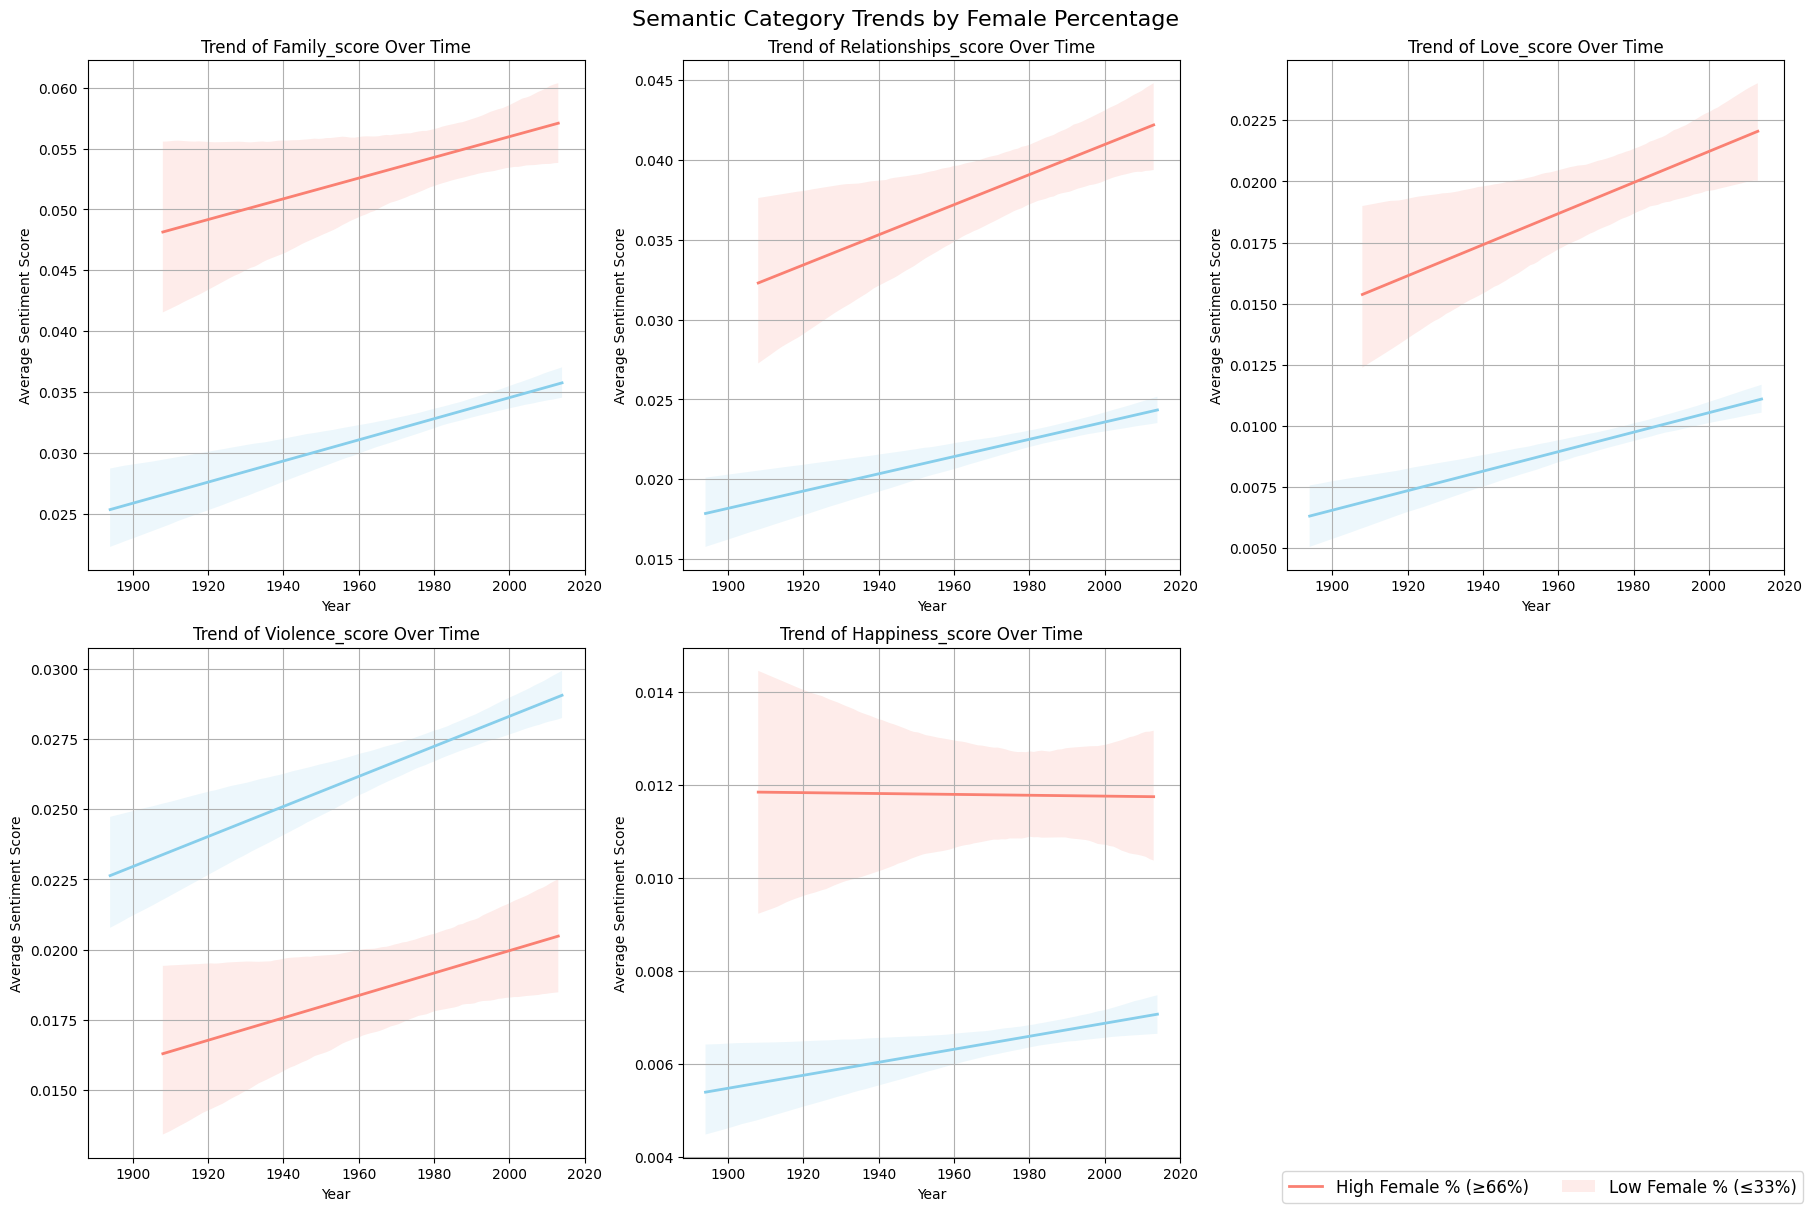

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a 'Year' column if the release date is in a datetime format
df['Year'] = pd.to_datetime(df['Movie_release_date']).dt.year

# Add a 'Subset' column to differentiate male-majority and female-majority movies
df['Subset'] = df.apply(
    lambda row: 'High Female % (≥66%)' if row['Female Percentage'] >= 66 else (
        'Low Female % (≤33%)' if row['Female Percentage'] <= 33 else None
    ),
    axis=1
)

# Filter out rows not part of the male or female subsets
df_filtered = df[df['Subset'].notnull()]

# Define colors for the subsets
subset_colors = {
    'High Female % (≥66%)': 'salmon',
    'Low Female % (≤33%)': 'skyblue'
}

# Create subplots for all sentiments
num_sentiments = len(top_5_sentiments) 
fig, axes = plt.subplots(
    nrows=(num_sentiments + 2) // 3,
    ncols=3,
    figsize=(18, 12),
    constrained_layout=True
)
axes = axes.flatten()

for idx, sentiment in enumerate(top_5_sentiments):
    if idx >= len(axes):
        break
    
    # Plot on the specified subplot axis
    for subset, color in subset_colors.items():
        subset_data = df_filtered[df_filtered['Subset'] == subset]
        sns.regplot(
            x='Year',
            y=sentiment,
            data=subset_data,
            scatter=False,
            ax=axes[idx],
            color=color,
            label=subset,
            line_kws={'linewidth': 2}
        )
    
    axes[idx].set_title(f'Trend of {sentiment.replace("_proximity", "").capitalize()} Over Time', fontsize=12)
    axes[idx].set_xlabel('Year', fontsize=10)
    axes[idx].set_ylabel('Average Sentiment Score', fontsize=10)
    axes[idx].grid(visible=True)

# Remove unused subplots
for idx in range(len(top_5_sentiments), len(axes)):
    fig.delaxes(axes[idx])

# Add a legend outside the subplots
fig.legend(
    labels=subset_colors.keys(),
    loc='lower right',
    ncol=2,
    fontsize=12
)

# Set the main title for the figure
fig.suptitle('Semantic Category Trends by Female Percentage', fontsize=16)

plt.show()


To generalize the previous trend analysis to all sentiment categories, the following code automates the generation and organization of plots for each category.

Automate Plot Generation:

Create Directory: Ensures an images folder exists to store all sentiment trend plots.
Generate Plots: Iterates through each sentiment category, creates a regression plot showing trends over time for both high and low female percentage movies, and saves each plot as a PNG file in the images folder.
Create Interactive HTML Viewer:

List Images: Retrieves all PNG files from the images directory.
Build HTML Interface: Constructs an HTML page with a dropdown menu allowing users to select and view any of the saved sentiment trend plots interactively.

In [94]:
# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Generate and save one plot per sentiment
for sentiment in sentiment_cols:
    fig, ax = plt.subplots(figsize=(10,6))

    for subset, color in subset_colors.items():
        subset_data = df_filtered[df_filtered['Subset'] == subset].dropna(subset=[sentiment, 'Year'])
        
        if len(subset_data) > 1:
            sns.regplot(
                x='Year',
                y=sentiment,
                data=subset_data,
                scatter=False,
                ax=ax,
                color=color,
                label=subset,
                line_kws={'linewidth': 2}
            )

    sentiment_label = sentiment.replace("_proximity", "").replace("_score", "").capitalize()
    ax.set_title(f"Trend of {sentiment_label} Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Sentiment Score")
    ax.grid(True)
    ax.legend()

    # Save the figure as a PNG file in the images folder
    filename = f"images/{sentiment_label}_trend.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory

print("All plots saved in the 'images' folder.")


All plots saved in the 'images' folder.


In [65]:
import os

# Directory where the images are stored
image_dir = 'images'

# Get all PNG files in the images directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files.sort()  # Sort for consistent ordering if desired

# We'll pick the first image as the default if it exists
default_image = image_files[0] if image_files else ''

# Construct the HTML
html_content = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>
<title>Image Selector</title>
<style>
  body {{ font-family: Arial, sans-serif; margin: 20px; }}
  #image-container {{
    margin-top: 20px;
  }}
  img {{
    max-width: 100%;
    height: auto;
  }}
</style>
</head>
<body>

<h1>Select an Image:</h1>
<select id="imageSelect">
"""

# Add an option for each image
for i, img in enumerate(image_files):
    selected_attr = 'selected' if i == 0 else ''
    html_content += f'  <option value="{image_dir}/{img}" {selected_attr}>{img}</option>\n'

html_content += f"""</select>

<div id="image-container">
  <img id="displayImage" src="{image_dir}/{default_image}" alt="Selected Image"/>
</div>

<script>
  const imageSelect = document.getElementById('imageSelect');
  const displayImage = document.getElementById('displayImage');

  imageSelect.addEventListener('change', function() {{
    const selectedSrc = imageSelect.value;
    displayImage.src = selectedSrc;
  }});
</script>

</body>
</html>
"""

# Save the HTML to a file
with open("image_selector.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("HTML file created: image_selector.html")


HTML file created: image_selector.html


# Exploring sentiment score as a function of female representation
We have seen significant differences between male-majority and female-majority movie datasets. Now, we examine whether these differences persist as the female percentage increases. The following plot visualizes how sentiment scores correlate with the female percentage in movies.

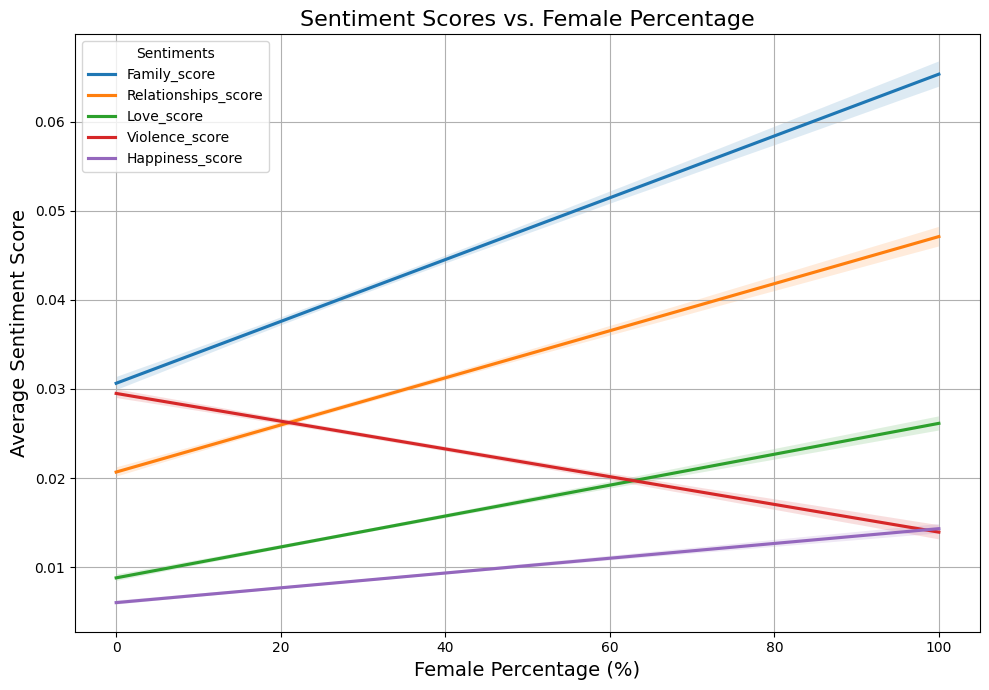

In [63]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 7))
# Define a color palette for the top 5 sentiments
colors = sns.color_palette("tab10", n_colors=5)

# Loop through each sentiment and plot
for sentiment, color in zip(top_5_sentiments, colors):
    sns.regplot(
        x='Female Percentage',
        y=sentiment,
        data=df,
        scatter=False,
        label=sentiment.replace('_proximity', '').capitalize(),
        color=color,
        # line_kws={'linewidth': 2}
    )

# Customize the plot
plt.xlabel('Female Percentage (%)', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Scores vs. Female Percentage', fontsize=16)
plt.legend(title='Sentiments')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [97]:
import pandas as pd
import plotly.express as px



df = df.explode('Movie_countries').reset_index(drop=True)

# Separate female-majority and male-majority movies
female_movies = df[df['Subset'] == 'High Female % (≥66%)']
male_movies = df[df['Subset'] == 'Low Female % (≤33%)']

# Define semantic score columns (assuming they end with '_proximity')
sentiment_cols = [col for col in df.columns if col.endswith('_proximity')]

# Group by country and calculate mean scores for female and male subsets
female_country_scores = female_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()
male_country_scores = male_movies.groupby('Movie_countries')[sentiment_cols].mean().reset_index()

# Combine the scores into a single DataFrame for comparison
country_comparison = female_country_scores.merge(
    male_country_scores,
    on='Movie_countries',
    how='outer',
    suffixes=('_female', '_male')
)

# Plotting the comparison for a specific sentiment (e.g., "love_proximity")
selected_sentiment = 'family_score_proximity'  # Adjust based on your actual column names

# Prepare data for plotting
data_to_plot_female = country_comparison[['Movie_countries', f'{selected_sentiment}_female']].dropna()
data_to_plot_female.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_female': 'Female_Majority_Score'
}, inplace=True)

data_to_plot_male = country_comparison[['Movie_countries', f'{selected_sentiment}_male']].dropna()
data_to_plot_male.rename(columns={
    'Movie_countries': 'country',
    f'{selected_sentiment}_male': 'Male_Majority_Score'
}, inplace=True)


In [98]:
country_comparison.head()

,Movie_countries,love_score_proximity_female,aggression_score_proximity_female,violence_score_proximity_female,family_score_proximity_female,happiness_score_proximity_female,sadness_score_proximity_female,fear_score_proximity_female,empowerment_score_proximity_female,relationships_score_proximity_female,...,empowerment_score_proximity_male,relationships_score_proximity_male,career_score_proximity_male,social_issues_score_proximity_male,emotional_complexity_score_proximity_male,heroism_score_proximity_male,conflict_resolution_score_proximity_male,adventure_score_proximity_male,mystery_score_proximity_male,technology_score_proximity_male
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002901,0.015474,0.010638,0.000967,0.009671,0.001934,0.007737,0.004836,0.008704,0.002901
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.086957,0.043478,0.000000,0.000000,0.000000,0.086957,0.043478,0.000000,0.000000
2,Algeria,0.000000,0.052632,0.052632,0.052632,0.00000,0.000000,0.000000,0.052632,0.052632,...,0.003220,0.000641,0.013223,0.018423,0.014492,0.003846,0.026388,0.019834,0.008706,0.000969
3,Argentina,0.024291,0.002204,0.007713,0.069868,0.00842,0.008243,0.005013,0.005208,0.049309,...,0.008295,0.035691,0.027188,0.010610,0.006072,0.008017,0.019523,0.017408,0.017488,0.006464
4,Armenia,0.000000,0.075000,0.075000,0.075000,0.00000,0.000000,0.025000,0.000000,0.000000,...,0.008065,0.076039,0.009848,0.032977,0.010282,0.029379,0.042826,0.013447,0.009848,0.006250


In [99]:

# Create choropleth map for Female-Majority Scores
fig_female = px.choropleth(
    data_to_plot_female,
    locations="country",
    locationmode='country names',
    color="Female_Majority_Score",
    hover_name="country",
    color_continuous_scale="Reds",
    title=f'Female-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Create choropleth map for Male-Majority Scores
fig_male = px.choropleth(
    data_to_plot_male,
    locations="country",
    locationmode='country names',
    color="Male_Majority_Score",
    hover_name="country",
    color_continuous_scale="Blues",
    title=f'Male-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Display the maps side by side using Plotly's subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=(
                        f'Female-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
                        f'Male-Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores'
                    ),
                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}]])

# Add Female-Majority map
fig.add_trace(fig_female.data[0], row=1, col=1)

# Add Male-Majority map
fig.add_trace(fig_male.data[0], row=1, col=2)

# Update layout
fig.update_layout(
    title_text=f'Comparison of {selected_sentiment.replace("_proximity", "").capitalize()} Scores by Gender Majority',
    geo=dict(
    showframe=False,
    showcoastlines=True,  # Enables coastlines
    coastlinecolor='black',
    showcountries=True,   # Enables country borders
    countrycolor='black',
    projection_type='equirectangular',  # Change the projection type as needed
    ),
    height=600,
    width=1200
)

fig.show()


In [28]:
data_to_plot = data_to_plot_male.merge(data_to_plot_female, on='country', how='inner')
data_to_plot['Female_majority'] =data_to_plot['Female_Majority_Score'] > data_to_plot['Male_Majority_Score']


In [29]:
data_to_plot

,country,Male_Majority_Score,Female_Majority_Score,Female_majority
0,Algeria,0.060916,0.052632,False
1,Argentina,0.040813,0.069868,True
2,Armenia,0.047190,0.075000,True
3,Australia,0.033791,0.062735,True
4,Austria,0.031318,0.031803,True
...,...,...,...,...
68,United Arab Emirates,0.036892,0.045662,True
69,United Kingdom,0.027355,0.052068,True
70,United States of America,0.027995,0.049746,True
71,Venezuela,0.049841,0.058150,True


In [ ]:
import plotly.express as px

# Create a choropleth map for Female-Majority Scores
fig = px.choropleth(
    data_to_plot,
    locations="country",
    locationmode='country names',
    color="Female_majority",
    hover_name="country",
    hover_data={
        "Male_Majority_Score": True,
        "Female_Majority_Score": True,
        "country":False,

    },
    title=f'Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
)

# Update layout for space optimization
fig.update_layout(
    title=dict(
        text=f'Majority Movies: {selected_sentiment.replace("_proximity", "").capitalize()} Scores',
        y=0.95,  # Position the title closer to the top edge
        x=0.5,
        xanchor='center',
        yanchor='top',
    ),
    margin=dict(
        l=10,  # Reduce left margin
        r=10,  # Reduce right margin
        t=40,  # Reduce top margin
        b=10   # Reduce bottom margin
    ),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='black',
        showcountries=True,
        countrycolor='black',
        projection_type='equirectangular',
    ),
    height=500,  # Optimize figure height
    width=900,   # Optimize figure width
)

# Display the figure
fig.show()


In [31]:
sentiment_cols

['love_score_proximity',
 'aggression_score_proximity',
 'violence_score_proximity',
 'family_score_proximity',
 'happiness_score_proximity',
 'sadness_score_proximity',
 'fear_score_proximity',
 'empowerment_score_proximity',
 'relationships_score_proximity',
 'career_score_proximity',
 'social_issues_score_proximity',
 'emotional_complexity_score_proximity',
 'heroism_score_proximity',
 'conflict_resolution_score_proximity',
 'adventure_score_proximity',
 'mystery_score_proximity',
 'technology_score_proximity']

In [32]:
country_comparison

,Movie_countries,love_score_proximity_female,aggression_score_proximity_female,violence_score_proximity_female,family_score_proximity_female,happiness_score_proximity_female,sadness_score_proximity_female,fear_score_proximity_female,empowerment_score_proximity_female,relationships_score_proximity_female,...,empowerment_score_proximity_male,relationships_score_proximity_male,career_score_proximity_male,social_issues_score_proximity_male,emotional_complexity_score_proximity_male,heroism_score_proximity_male,conflict_resolution_score_proximity_male,adventure_score_proximity_male,mystery_score_proximity_male,technology_score_proximity_male
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002901,0.015474,0.010638,0.000967,0.009671,0.001934,0.007737,0.004836,0.008704,0.002901
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.086957,0.043478,0.000000,0.000000,0.000000,0.086957,0.043478,0.000000,0.000000
2,Algeria,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,...,0.003220,0.000641,0.013223,0.018423,0.014492,0.003846,0.026388,0.019834,0.008706,0.000969
3,Argentina,0.024291,0.002204,0.007713,0.069868,0.008420,0.008243,0.005013,0.005208,0.049309,...,0.008295,0.035691,0.027188,0.010610,0.006072,0.008017,0.019523,0.017408,0.017488,0.006464
4,Armenia,0.000000,0.075000,0.075000,0.075000,0.000000,0.000000,0.025000,0.000000,0.000000,...,0.008065,0.076039,0.009848,0.032977,0.010282,0.029379,0.042826,0.013447,0.009848,0.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Uruguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007178,0.031027,0.033965,0.005159,0.004343,0.004343,0.024230,0.016181,0.015127,0.005159
100,Venezuela,0.004545,0.004545,0.000000,0.058150,0.004545,0.000000,0.000000,0.000000,0.004545,...,0.020038,0.047938,0.015723,0.012008,0.004034,0.009979,0.024157,0.008272,0.023825,0.012008
101,Vietnam,0.043783,0.004566,0.004566,0.138421,0.027211,0.027848,0.018172,0.000000,0.090240,...,0.005291,0.031579,0.015873,0.006154,0.000000,0.014063,0.010582,0.008772,0.014926,0.000000
102,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018868,0.075472,0.018868,0.000000,0.000000,0.000000,0.018868,0.018868,0.018868,0.000000


In [72]:
# Initialize a list to hold all the choropleth traces
data_traces = []

for i, sentiment in enumerate(sentiment_cols):
    # Prepare data for female-majority movies
    data_to_plot_female = country_comparison[['Movie_countries', f'{sentiment}_female']].dropna()
    data_to_plot_female.rename(columns={
        'Movie_countries': 'country',
        f'{sentiment}_female': 'Female_Majority_Score'
    }, inplace=True)

    # Prepare data for male-majority movies
    data_to_plot_male = country_comparison[['Movie_countries', f'{sentiment}_male']].dropna()
    data_to_plot_male.rename(columns={
        'Movie_countries': 'country',
        f'{sentiment}_male': 'Male_Majority_Score'
    }, inplace=True)

    # Merge female and male data
    data_to_plot = data_to_plot_male.merge(data_to_plot_female, on='country', how='inner')
    data_to_plot['Female_majority'] = data_to_plot['Female_Majority_Score'] > data_to_plot['Male_Majority_Score']
    
    # Define a custom color scale based on the Female_majority column
    data_to_plot['color'] = data_to_plot['Female_majority'].apply(lambda x: 'salmon' if x else 'skyblue')

    # Create custom hovertext
    data_to_plot['hover_text'] = (
        "Country: " + data_to_plot['country'] +
        "<br>Male Majority Score: " + data_to_plot['Male_Majority_Score'].astype(str) +
        "<br>Female Majority Score: " + data_to_plot['Female_Majority_Score'].astype(str) +
        "<br>Sentiment: " + sentiment
    )

    # Update the trace
    choropleth_trace = go.Choropleth(
        locations=data_to_plot['country'],
        locationmode='country names',
        z=data_to_plot['Female_majority'].astype(int),
        colorscale=[[0, 'skyblue'], [1, 'salmon']],
        showscale=False,  # Disable the color bar
        text=data_to_plot['hover_text'],  # Use custom hover text
        hoverinfo='text'  # Display only the custom hover text
    )
    data_traces.append(choropleth_trace)


In [73]:
# Create dropdown menu buttons
buttons = []
for i, sentiment in enumerate(sentiment_cols):
    button = dict(
        label=sentiment.replace("_proximity", "").capitalize(),
        method='update',
        args=[
            {'visible': [j == i for j in range(len(sentiment_cols))]},  # Toggle visibility
            {'title': f'Majority Movies: {sentiment.replace("_proximity", "").capitalize()} Scores'}
        ]
    )
    buttons.append(button)


In [86]:
# Layout with improved legend
layout = go.Layout(
    title=f'Majority Movies: {sentiment_cols[0].replace("_proximity", "").capitalize()} Scores',
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='black',
        showcountries=True,
        countrycolor='black',
        projection_type='equirectangular',
    ),
    margin=dict(l=10, r=10, t=100, b=10),
    height=600,
    width=1000,
    annotations=[
        dict(
            x=0.05,  # Position for "Female Majority"
            y=1.02,
            xref="paper",
            yref="paper",
            text='<span style="color:salmon;">&#9632;</span> Female Majority',
            showarrow=False,
            font=dict(size=12),
        ),
        dict(
            x=0.05,  # Position for "Not Female Majority"
            y=0.98,
            xref="paper",
            yref="paper",
            text='<span style="color:skyblue;">&#9632;</span> Male Majority',
            showarrow=False,
            font=dict(size=12),
        ),
    ],
)



In [89]:
# Create the figure with all traces and the defined layout
fig = go.Figure(data=data_traces, layout=layout)

# Display the interactive figure
fig.show()

# Save the figure as an HTML file
fig.write_html("geographic_sentiment_score.html")
